## Read the input data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "random" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 2888, number of features = 20
Number of samples = 721, number of features = 20


In [17]:
X_test

tensor([[0.0510, 0.0355, 0.0878,  ..., 0.0693, 0.0495, 0.0700],
        [0.0610, 0.0514, 0.0707,  ..., 0.0680, 0.0453, 0.0509],
        [0.0433, 0.0230, 0.0855,  ..., 0.0724, 0.0517, 0.0685],
        ...,
        [0.0472, 0.0264, 0.0825,  ..., 0.0726, 0.0504, 0.0653],
        [0.0519, 0.0295, 0.0888,  ..., 0.0726, 0.0519, 0.0610],
        [0.0255, 0.0146, 0.0967,  ..., 0.1026, 0.0586, 0.0601]],
       device='cuda:0')

In [18]:
#mask = (y_train > 57).flatten()
mask = ((y_train <= 1000) & (y_train > 50)).flatten()
X_train = X_train[mask]
y_train = y_train[mask]


#mask = (y_test > 57).flatten()
mask = ((y_test <= 1000) & (y_test > 50)).flatten()
X_test = X_test[mask]
y_test = y_test[mask]

In [21]:
import torch
import numpy as np

def downsample_histogram_bins(X, y, num_bins=50, max_count=50, seed=42):
    y_np = y.cpu().numpy()
    X_np = X.cpu().numpy()

    # Create histogram
    counts, bin_edges = np.histogram(y_np, bins=num_bins)
    bin_indices = np.digitize(y_np, bin_edges) - 1

    # Collect indices to keep
    selected_indices = []

    rng = np.random.default_rng(seed)

    for bin_idx in range(num_bins):
        idx_in_bin = np.where(bin_indices == bin_idx)[0]
        if len(idx_in_bin) > max_count:
            sampled = rng.choice(idx_in_bin, size=max_count, replace=False)
        else:
            sampled = idx_in_bin
        selected_indices.extend(sampled)

    selected_indices = np.array(selected_indices)

    # Convert back to torch tensors
    X_filtered = torch.tensor(X_np[selected_indices], device=X.device)
    y_filtered = torch.tensor(y_np[selected_indices], device=y.device)

    return X_filtered, y_filtered

# Example usage
X_train, y_train = downsample_histogram_bins(X_train.cpu(), y_train.cpu().squeeze(), num_bins=50, max_count=200)
X_test, y_test = downsample_histogram_bins(X_test.cpu(), y_test.cpu().squeeze(), num_bins=50, max_count=200)


In [22]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 35.87621307373047
Average OGT of the train set = 33.96585464477539


In [23]:
# Downsampling

# Example range
r1, r2 = 20.0, 38.0

# Suppose y_train is a NumPy array
mask_in_range = (y_train.squeeze() >= r1) & (y_train.squeeze() <= r2)
mask_in_range_test = (y_test.squeeze() >= r1) & (y_test.squeeze() <= r2)
print(len(y_train))
mask_out_range = ~mask_in_range
mask_out_range_test = ~mask_in_range_test

# Indices of samples within the range
in_range_indices = np.where(mask_in_range.cpu())[0]
in_range_indices_test = np.where(mask_in_range_test.cpu())[0]

# Set the fraction to keep
keep_fraction = 0.3  # keep 50% of values in the range
num_to_keep = int(keep_fraction * len(in_range_indices))
num_to_keep_test = int(keep_fraction * len(in_range_indices_test))

# Randomly select indices to keep
np.random.seed(42)  # for reproducibility
keep_indices = np.random.choice(in_range_indices, size=num_to_keep, replace=False)
keep_indices_test = np.random.choice(in_range_indices_test, size=num_to_keep_test, replace=False)

# Combine with indices outside the range
final_indices = np.concatenate([keep_indices, np.where(mask_out_range.cpu())[0]])
final_indices_test = np.concatenate([keep_indices_test, np.where(mask_out_range_test.cpu())[0]])

# Downsampled y_train and associated X_train
y_train = y_train[final_indices].cpu()
print(len(y_train))
X_train = X_train[final_indices].cpu()  # if you have corresponding X_train

y_test = y_test[final_indices_test].cpu()
X_test = X_test[final_indices_test].cpu()  # if you have corresponding X_train

2230
1245


1245

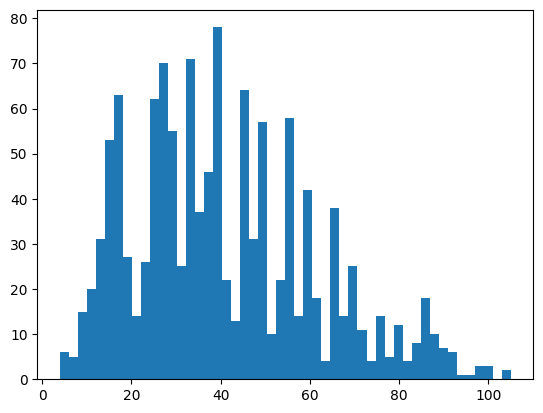

In [5]:
plt.hist(y_train.cpu(), bins = 50)
len(y_train.cpu())

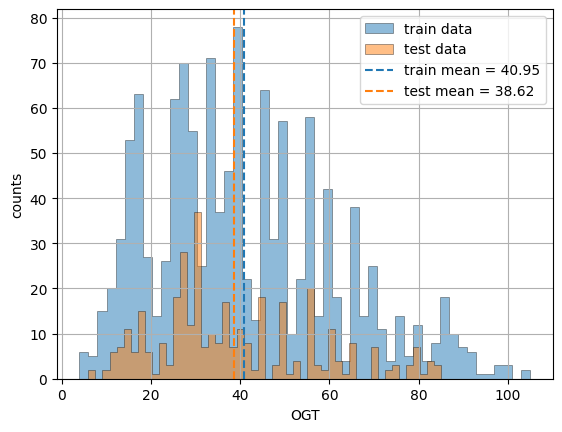

In [24]:
hist = plt.hist(y_train.cpu(), bins = 50, density = False, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
hist = plt.hist(y_test.cpu(), bins = 50, density = False, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:orange')
mean_value = y_train.cpu().mean().item()
plt.axvline(mean_value, color='tab:blue', linestyle='--', linewidth=1.5, label=f'train mean = {mean_value:.2f}')
mean_value = y_test.cpu().mean().item()
plt.axvline(mean_value, color='tab:orange', linestyle='--', linewidth=1.5, label=f'test mean = {mean_value:.2f}')


plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

## Initial prediction

In [25]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

# model = XGBRegressor(
#     n_estimators=100,
#     max_depth=5,
#     learning_rate=0.03,
#     reg_alpha=1.0,
#     reg_lambda=1.0
# )

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 7.19, R2 = 0.84
XGBoost baseline CV RMSE (all features) = 7.32, R2 = 0.87


In [26]:
cv_pearson_curve

NameError: name 'cv_pearson_curve' is not defined

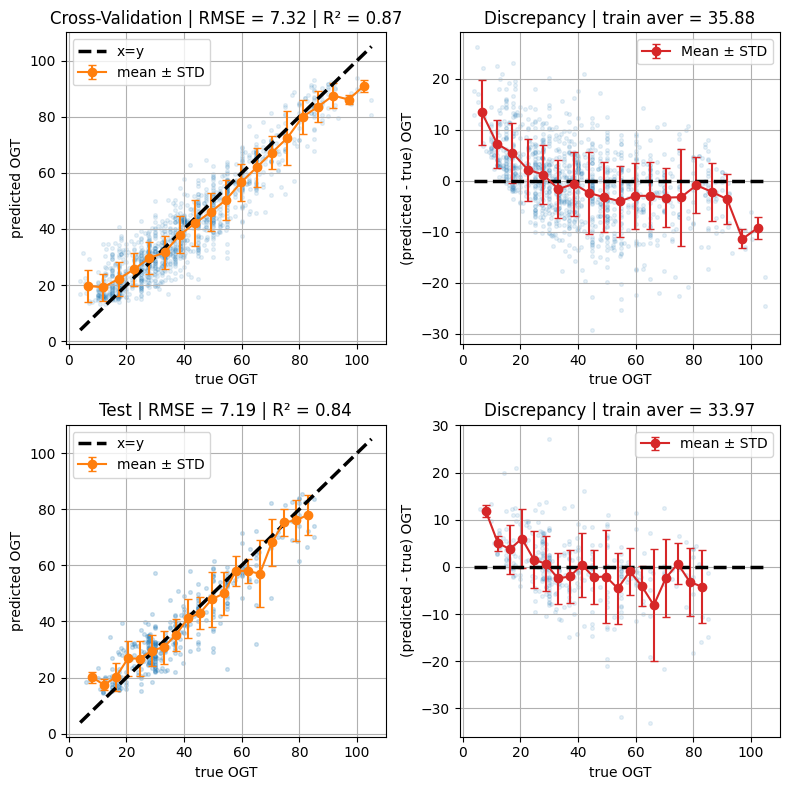

In [27]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers_cv_old, mean_diff_cv_old, std_diff_cv_old = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers_test_old, mean_diff_test_old, std_diff_test_old = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

In [28]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())
num_bins=20
#model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=100,learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())

y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

#y_true_cv = y_true_cv.flatten()
# y_pred_cv = y_pred_cv.flatten()

#X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
#preds = model.predict(X_train.cpu())
rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)
print(f"rmse_cv = {rmse_cv}; r2_cv = {r2_cv}")

plt.figure()
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:green', capsize=3, label='CV mean ± STD')

plt.plot(y_test.cpu(), y_test.cpu(), c="black")
#plt.scatter(y_true_cv, y_pred_cv, alpha= 0.1)



rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)
print(f"rmse_test = {rmse_test}; r2_test = {r2_test}")

plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:orange", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().flatten(), y_pred_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.legend()


ValueError: too many values to unpack (expected 3)

## Step 2: Train Models on Data Segments

low_q = 20; high_q = 45
num low = 205; num mid = 534; num high = 506;


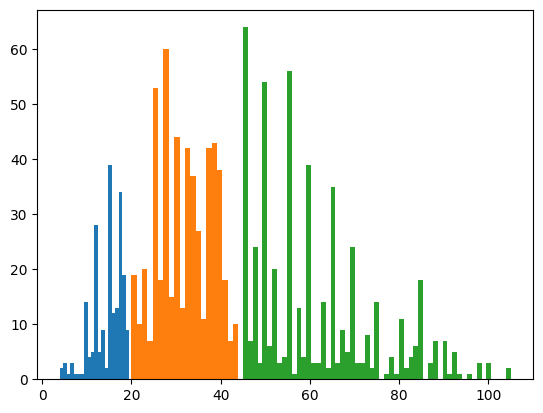

In [29]:
#y_train_log = np.log1p(y_train)
#y_test_log = np.log1p(y_test)

# Flatten y_train to 1D
y_train_flat = y_train.cpu().flatten()

# Compute quantiles from the flattened version
low_q = 20#np.quantile(y_train_flat, 1/3)
high_q = 45#np.quantile(y_train_flat, 2/3)
print(f"low_q = {low_q}; high_q = {high_q}")

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
high_mask = y_train_flat >= high_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask].cpu(), y_train_flat[low_mask].cpu()
X_mid, y_mid   = X_train[mid_mask].cpu(), y_train_flat[mid_mask].cpu()
X_high, y_high = X_train[high_mask].cpu(), y_train_flat[high_mask].cpu()

plt.hist(y_low, bins=20)
plt.hist(y_mid, bins=20)
plt.hist(y_high, bins=55)

print(f"num low = {len(y_low)}; num mid = {len(y_mid)}; num high = {len(y_high)};")

In [54]:
high_q

45

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05)
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
model_mid  =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_mid, y_mid)
model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)

In [31]:
def evaluate_model(model, X_test, y_test, segment_name):
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"\nPerformance on {segment_name} segment:")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    return r2, mae, rmse

In [32]:
# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()
# low_q = np.quantile(y_train.flatten(), 1/3)
# high_q = np.quantile(y_train.flatten(), 2/3)

# # Create test masks
# low_mask_test  = y_test_flat < low_q
# mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
# high_mask_test = y_test_flat >= high_q

low_mask_test  = y_test_flat < low_q
mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
high_mask_test = y_test_flat >= high_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test].cpu(), y_test_flat[low_mask_test].cpu()
X_test_mid, y_test_mid   = X_test[mid_mask_test].cpu(), y_test_flat[mid_mask_test].cpu()
X_test_high, y_test_high = X_test[high_mask_test].cpu(), y_test_flat[high_mask_test].cpu()

In [33]:

# Evaluate each model
evaluate_model(model_low,  X_test_low.cpu(),  y_test_low.cpu(),  "Low")
evaluate_model(model_mid,  X_test_mid.cpu(),  y_test_mid.cpu(),  "Mid")
evaluate_model(model_high, X_test_high.cpu(), y_test_high.cpu(), "High")


Performance on Low segment:
  R²   : -0.103
  MAE  : 2.495
  RMSE : 3.091

Performance on Mid segment:
  R²   : 0.369
  MAE  : 3.558
  RMSE : 4.445

Performance on High segment:
  R²   : 0.771
  MAE  : 4.164
  RMSE : 5.640


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.7712730169296265, 4.1639256, 5.6401124)

In [34]:
gain_dict = model_low.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_low)
print(f"Tot gain in low model = {total_gain}")

gain_dict = model_mid.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_mid)
print(f"Tot gain in mid model = {total_gain}")

gain_dict = model_high.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_high)
print(f"Tot gain in high model = {total_gain}")

Tot gain in low model = 1.1970894929839344
Tot gain in mid model = 2.793640976095021
Tot gain in high model = 12.318816784342287


## Step 3: Normalize Sensitivity via Target Transform or Weights


### Log-Transforming Target

In [17]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train_log.cpu(), X_test.cpu(), y_test_log.cpu(), weights=None) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 38.27, R2 = -3.44
XGBoost baseline CV RMSE (all features) = 0.23, R2 = 0.79


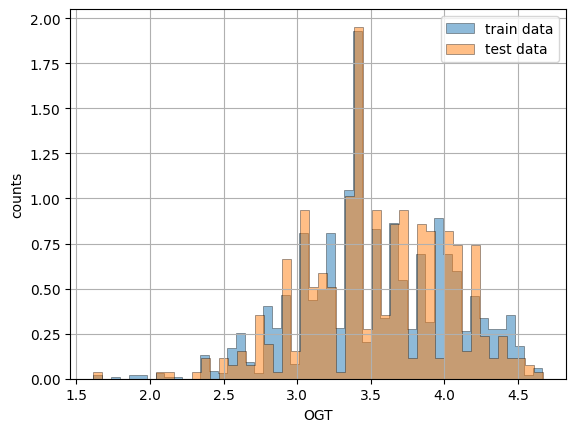

In [18]:
hist = plt.hist(y_train_log.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test_log.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

In [13]:
y_true_cv = np.expm1(y_true_cv)
y_pred_cv = np.expm1(y_pred_cv)
y_pred_test = np.expm1(y_pred_test)

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

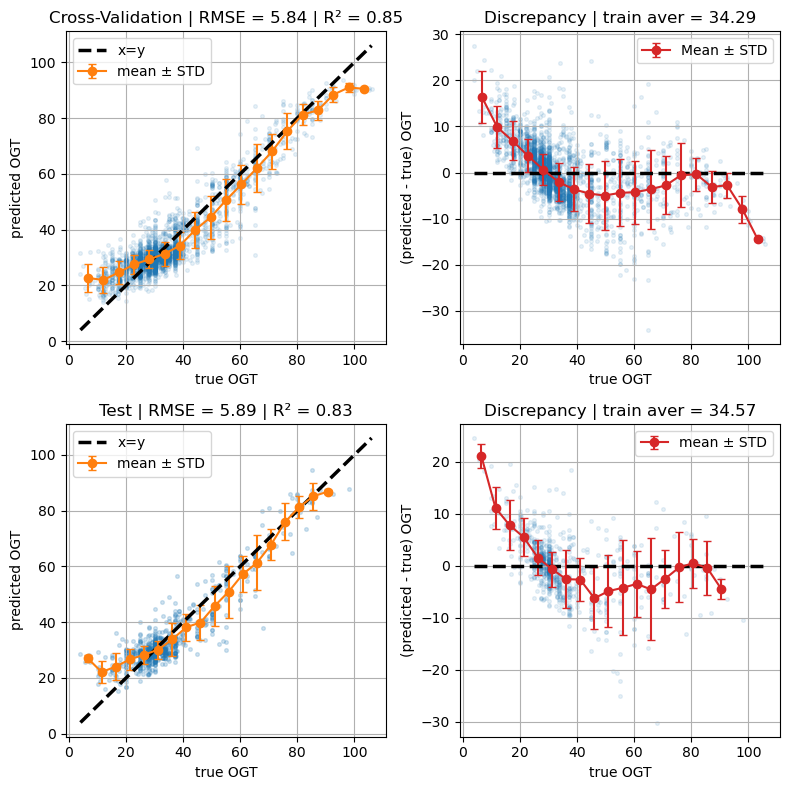

In [63]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

### Weighting Samples

[1.96000001e+02 1.66200000e+03 6.15000001e+02 2.12000001e+02
 1.22000001e+02 6.50000010e+01 1.50000010e+01 1.00000100e+00]
1662
[1.84511914 1.         1.60357417 1.83589547 1.88777863 1.92063797
 1.94946195 1.95753267]


1.0

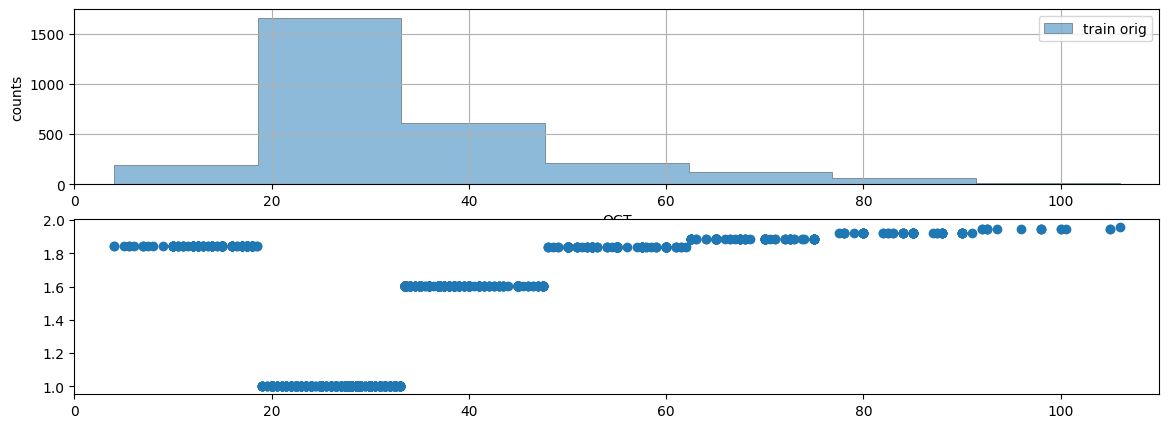

In [11]:
from utils.utils import train_xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from utils.utils import train_xgboost, calculate_aver_std

y_np = y_train.squeeze().cpu().numpy()

# Step 1: Bin the continuous values
num_bins = 7
bin_edges = np.linspace(y_np.min(), y_np.max(), num_bins + 1)
bin_indices = np.digitize(y_np, bins=bin_edges) - 1

# Step 2: Count samples in each bin
bin_counts = np.bincount(bin_indices, minlength=num_bins)

# Step 3: Scale weights between 1 (for max bin count) and 50 (for min bin count)
min_count = bin_counts.min()
max_count = bin_counts.max()

# Avoid division by zero if bins are empty
bin_counts_safe = bin_counts + 1e-6

# Normalize so max_count → weight 1, min_count → weight 50
bin_weights = 1- bin_counts / max_count#(max_count / bin_counts_safe)
bin_weights = bin_weights / sum(bin_weights)
bin_weights = 1 + bin_weights*6
print(bin_counts_safe)
print(max_count)
print(bin_weights)
# bin_weights[-1]=0
# bin_weights[-2]=0
# bin_weights[-3]=0
#bin_weights = 1 + (bin_weights - 1) * (5 - 1) / (bin_weights.max() - 1)

# Step 4: Assign sample weights
weights = bin_weights[bin_indices]
#weights /= weights.mean()

plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1) 
hist = plt.hist(y_train.cpu(), bins =num_bins, density = False, label = "train orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.xlim([0, 110])
plt.legend();

plt.subplot(2, 1, 2) 
plt.scatter(y_train.cpu(), weights)
plt.xlim([0, 110])
min(weights)

In [12]:
model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=weights, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")
print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")

XGBoost baseline CV RMSE (all features) = 6.06, R2 = 0.84
XGBoost baseline test RMSE (all features) = 6.12, R2 = 0.81


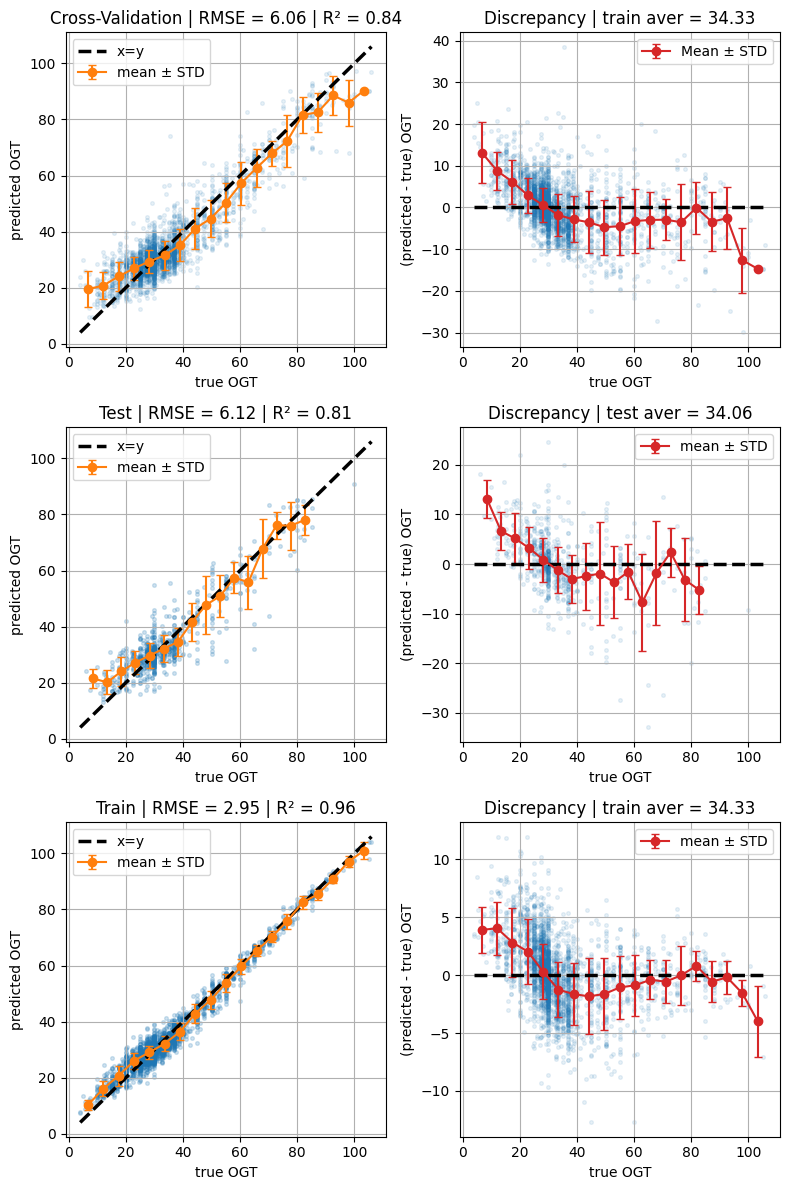

In [15]:
plt.figure(figsize=(8, 12))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(3, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(3, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(3, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 2, 5) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_train.cpu())
plt.scatter(y_train.cpu(),y_pred, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_train.cpu().squeeze(), y_pred.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
rmse_train = np.sqrt(mean_squared_error(y_train.cpu(),y_pred))
r2_train = r2_score(y_train.cpu(),y_pred)
plt.title(f"Train | RMSE = {rmse_train:.2f} | R² = {r2_train:.2f}")
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 6) 
y_test = y_test.cpu()
diff = [y_pred.squeeze()[i] - y_train.cpu().squeeze().numpy()[i]  for i in range(len(y_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_train.cpu().squeeze().numpy(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_train.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

In [30]:
y_train.cpu().squeeze().numpy()

array([  5. ,   5.5,   4. , ..., 100. , 100. , 100.5], dtype=float32)

In [31]:
y_pred.squeeze()

array([10.502221,  7.775348,  5.621496, ..., 94.268684, 96.086395,
       95.95639 ], dtype=float32)

### Test Generalization Between Segments

In [35]:
y_low[:10]
preds

NameError: name 'preds' is not defined

In [36]:
preds = model_low.predict(X_low)
preds[:10]

array([5.198404 , 7.7124023, 7.467184 , 5.952948 , 7.256805 , 6.3098254,
       8.538175 , 9.107771 , 8.061972 , 8.18696  ], dtype=float32)

In [37]:
# y_low = np.expm1(y_low)
# y_mid = np.expm1(y_mid)
# y_high = np.expm1(y_high)


In [38]:
# y_test_low = np.expm1(y_test_low)
# y_test_mid = np.expm1(y_test_mid)
# y_test_high = np.expm1(y_test_high)

In [39]:
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
r2_test

-8.491223335266113

In [40]:
#model_mid  =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_mid, y_mid)
model_mid  =  XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05).fit(X_mid, y_mid)

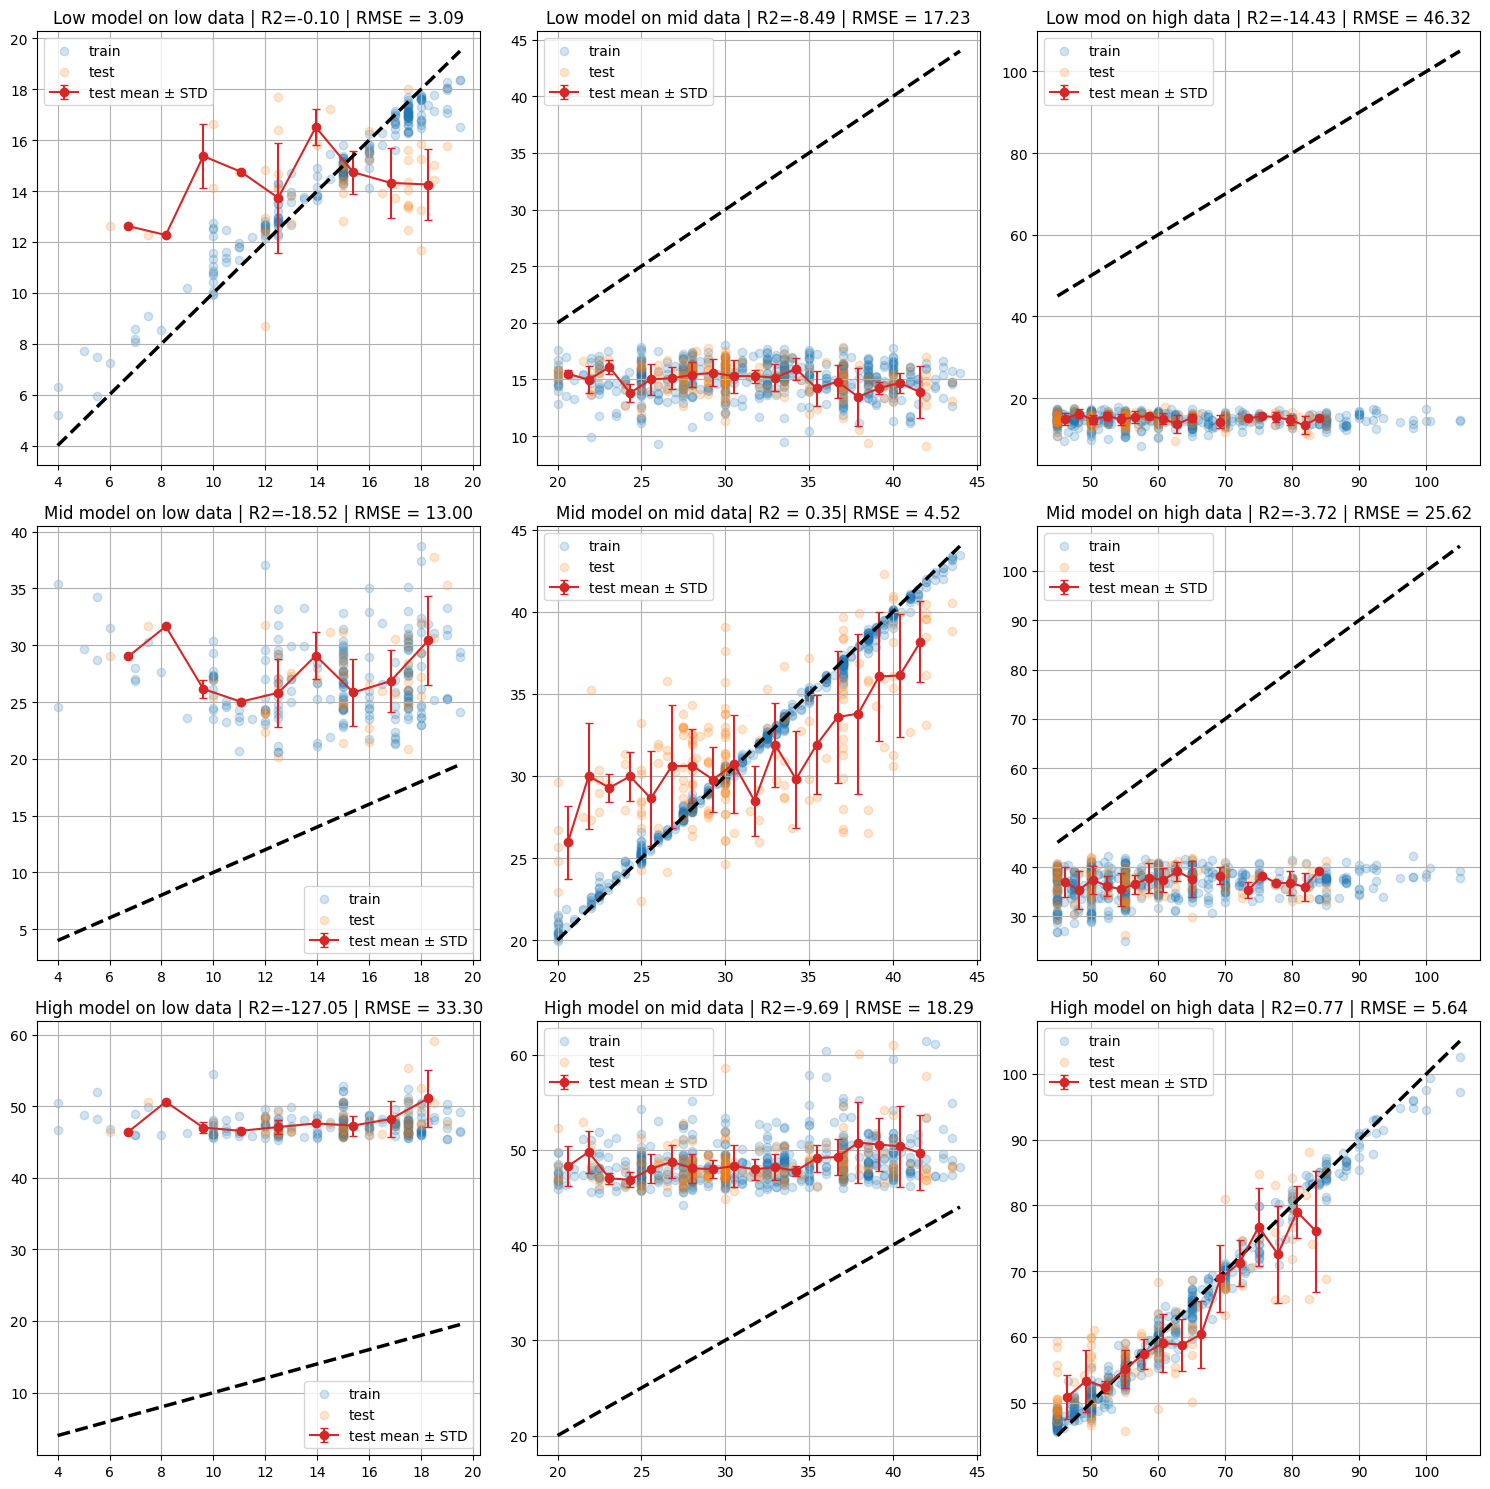

In [41]:
plt.figure(figsize=(15, 15))


plt.subplot(3, 3, 1) 
preds = model_low.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
preds_test = model_low.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2) 
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 3) 
preds = model_low.predict(X_high)
preds_test = model_low.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_low.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 4) 
preds = model_mid.predict(X_low)
preds_test = model_mid.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_low.flatten(), model_mid.predict(X_test_low), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 5) 
preds = model_mid.predict(X_mid)
preds_test = model_mid.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), model_mid.predict(X_test_mid), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on mid data| R2 = {r2_test:.2f}| RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 6) 
preds = model_mid.predict(X_high)
preds_test = model_mid.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_mid.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 7) 
preds = model_high.predict(X_low)
preds_test = model_high.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_low.flatten(), model_high.predict(X_test_low), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 8) 
preds = model_high.predict(X_mid)
preds_test = model_high.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), model_high.predict(X_test_mid), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 9) 
preds = model_high.predict(X_high)
preds_test = model_high.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
r2_test = r2_score(y_test_high.flatten(), preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_high.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers_l, mean_diff_l, std_diff_l = calculate_aver_std(y_test_high.flatten(), preds_test, 15)
plt.errorbar(bin_centers_l, mean_diff_l, yerr=std_diff_l, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()

In [42]:
model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())


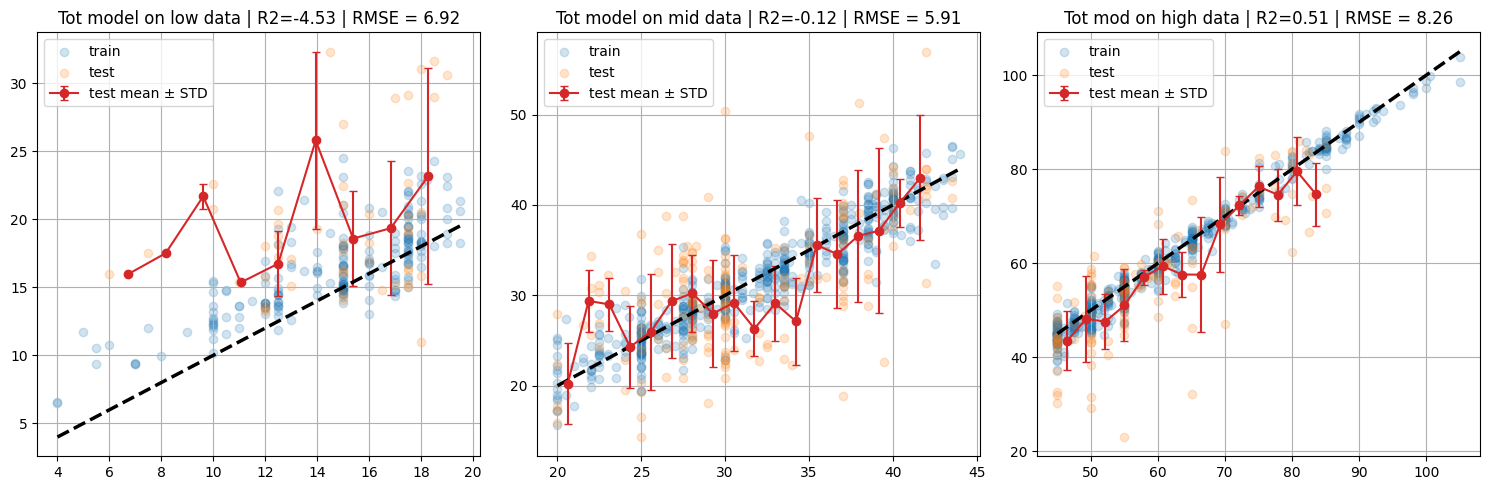

In [43]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1) 
preds = model.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
preds_test = model.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Tot model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2) 
preds = model.predict(X_mid)
preds_test = model.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Tot model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(1, 3, 3) 
preds = model.predict(X_high)
preds_test = model.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers_ll, mean_diff_ll, std_diff_ll = calculate_aver_std(y_test_high.flatten(), preds_test, 15)
plt.errorbar(bin_centers_ll, mean_diff_ll, yerr=std_diff_ll, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Tot mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()

In [44]:
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
y_test_high.flatten()

tensor([ 55.0000,  70.0000,  68.0000,  70.0000,  61.0000,  65.0000,  75.0000,
         55.0000,  58.5000,  55.0000,  85.0000,  80.0000,  63.0000,  55.0000,
         70.0000,  65.0000,  65.0000,  92.5000,  65.0000,  65.0000,  75.0000,
         57.5000,  65.0000,  60.0000,  66.5000,  87.5000,  65.0000,  65.0000,
         60.0000,  63.0000,  88.0000,  60.0000,  78.0000,  60.0000,  60.0000,
         70.0000, 106.0000,  80.0000,  55.0000,  61.0000,  55.0000,  67.5000,
         60.0000,  70.0000,  60.0000,  65.0000,  55.0000,  55.0000,  55.0000,
         55.0000,  66.0000,  55.0000,  90.0000,  55.0000,  93.5000,  82.5000,
         60.0000,  65.0000,  66.5000,  55.0000,  96.0000,  55.0000,  60.0000,
         73.7500,  67.0000,  55.0000,  55.0000,  65.0000,  70.0000,  59.0000,
         60.0000,  58.0000,  55.0000,  57.5000,  80.0000,  65.0000,  60.0000,
         78.0000,  55.0000,  98.0000,  57.5000,  55.0000,  60.0000,  60.0000,
         65.0000])

In [45]:
preds_test

array([20.950802, 16.38699 , 17.901562, 20.002369, 22.644514, 18.399143,
       24.41452 , 20.224846, 20.817213, 18.012907, 17.84097 , 19.530651,
       18.69564 , 17.807138, 19.026072, 19.84941 , 17.248165, 18.164268,
       20.153627, 19.46568 , 20.117142, 23.048092, 22.903336, 18.687984,
       21.472334, 18.86089 , 19.572348, 17.628777, 21.33745 , 16.25778 ,
       18.25738 , 18.552498, 20.303951, 21.062202, 20.889841, 24.108276,
       19.17922 , 19.102001, 19.520498, 17.55997 , 16.796124, 17.83459 ,
       17.062977, 22.47972 , 15.964989, 17.371206, 22.940733, 17.142338,
       22.006357, 19.362398, 21.041834, 20.641148, 18.537   , 21.41995 ,
       19.555195, 17.981716, 19.371874, 16.801044, 16.754814, 21.79339 ,
       18.877054, 17.753548, 18.148361, 16.30684 , 23.49551 , 20.574594,
       21.700272, 17.992468, 21.108316, 21.767187, 23.98199 , 18.77506 ,
       20.112827, 17.224653, 24.318249, 17.196655, 15.284012, 17.794113,
       16.135479, 18.385748, 25.052837, 13.685175, 

### Top important features

Top 10 most important features by gain in the low model:
Q: 36.80
A: 22.65
Y: 19.97
C: 19.04
T: 18.40
V: 18.14
M: 16.99
E: 16.20
P: 15.14
W: 15.04


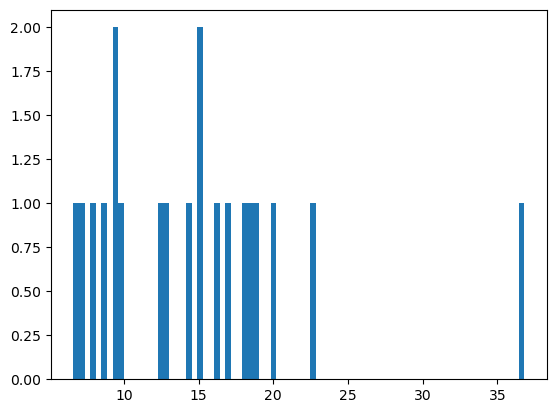

In [23]:
# Get feature importance scores (by gain)
gain_dict = model_low.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the low model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the mid model:
E: 383.19
S: 140.27
F: 131.00
T: 129.07
C: 121.30
A: 107.78
L: 106.61
R: 99.56
Y: 91.00
W: 90.60


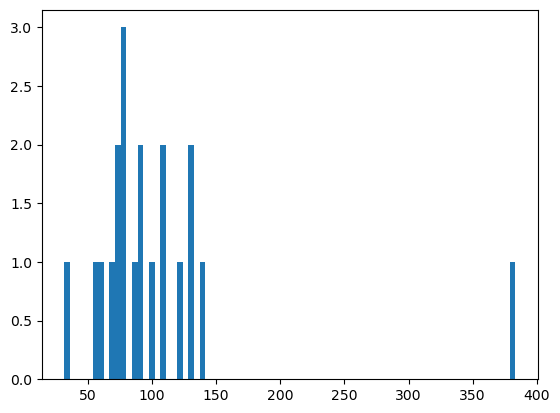

In [24]:
# Get feature importance scores (by gain)
gain_dict = model_mid.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the mid model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the high model:
Q: 2744.71
D: 743.89
L: 660.48
H: 295.31
N: 245.64
Y: 209.81
E: 191.42
A: 179.44
T: 155.46
F: 145.55


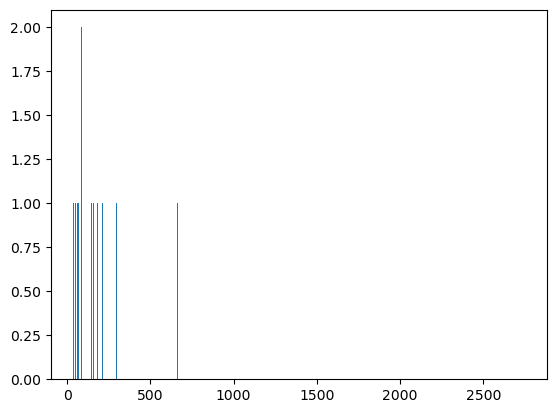

In [25]:
# Get feature importance scores (by gain)
gain_dict = model_high.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the high model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=800);

### Vizualization 

Shape of the projected data = (2888, 2)


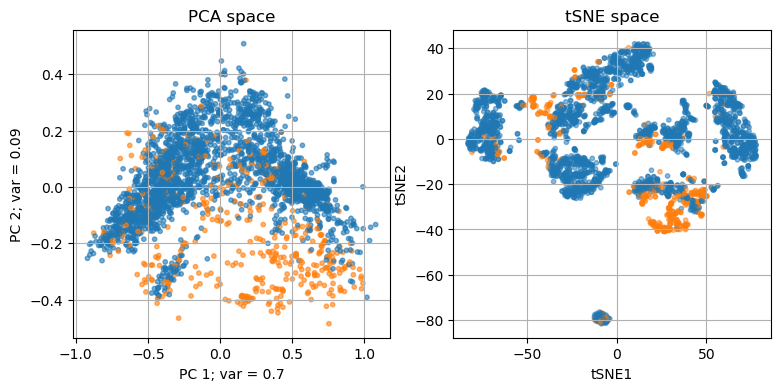

In [28]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [5 if yi>45  else 0 for yi in y_train]

colors = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train_masked, None, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train_masked, colors);

Shape of the projected data = (2888, 2)


Text(0.5, 0.98, 'Expression level of Q')

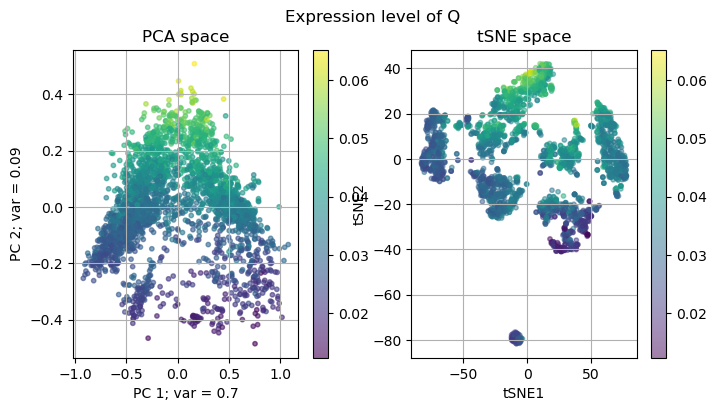

In [29]:
feature_name = 'Q'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_train[:, idx]
feature_expression = feature_expression.cpu()

from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
pca_run_and_plot(X_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train.cpu(), 50, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

In [58]:
max(feature_expression)


tensor(3, dtype=torch.int32)

### Mixture of experts model

In [44]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# --- 1. Label each sample as low, mid, or high OGT group
def label_ogt_range(y, low_thresh=20, high_thresh=45):
    labels = []
    for val in y:
        if val < low_thresh:
            labels.append('low')
        elif val <= high_thresh:
            labels.append('mid')
        else:
            labels.append('high')
    return np.array(labels)

# Assign labels
range_labels = label_ogt_range(y_train)

le = LabelEncoder()
range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2

label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)

range_labels_test = label_ogt_range(y_test)
range_ids_test = np.vectorize(label_to_int.get)(range_labels_test)

(array([ 50., 200., 104.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

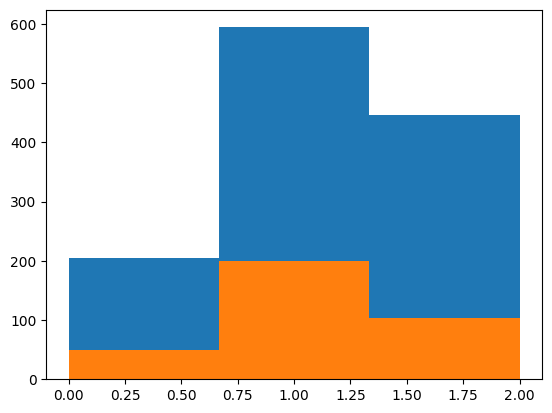

In [45]:
plt.hist(range_ids, bins=3)
plt.hist(range_ids_test, bins=3)

In [46]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Encode classes (0 = low, 1 = mid, 2 = high)
#range_ids = le.transform(label_ogt_range(y_train))

# Compute class weights
classes = np.unique(range_ids)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)
#weights = [4.720125786163522, 0.4315078338364237, 2.1245576786978]

# Convert to dictionary format for xgboost
class_weights = dict(zip(classes, weights))

#class_weights[1]=0.01

# Pass weights to each sample
sample_weights = np.array([class_weights[c] for c in range_ids])

class_weights

{0: 2.024390243902439, 1: 0.6986531986531986, 2: 0.9304932735426009}

In [47]:
label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)
range_ids

array([1, 1, 1, ..., 2, 2, 2])

In [48]:
# --- 2. Train gating model (classifier)
#gating_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')



num_classes = 3
gating_model = XGBClassifier(
    n_jobs=-1,
    tree_method="hist",
    objective="multi:softmax",   # Multi-class classification
    num_class=num_classes,       # Number of target classes
    eval_metric="mlogloss",      # Suitable for multi-class
)

# gating_model = XGBClassifier(
#     objective="multi:softprob", 
#     num_class=3,
#     eval_metric="mlogloss",
# )


gating_model.fit(X_train.cpu(), range_ids,sample_weight=sample_weights )  # Predicts soft assignments to experts



# --- 4. Get gating probabilities (soft weights for each expert)
gate_probs = gating_model.predict_proba(X_test.cpu())  # Shape: (n_samples, 3)

In [49]:
gate_probs

array([[8.9873215e-03, 9.8969543e-01, 1.3172124e-03],
       [9.9214810e-01, 7.7621941e-03, 8.9768604e-05],
       [1.4617807e-01, 8.5267508e-01, 1.1469243e-03],
       ...,
       [3.6736208e-06, 2.1476751e-04, 9.9978155e-01],
       [2.7191503e-05, 5.7755201e-04, 9.9939525e-01],
       [8.8782244e-06, 1.8339154e-04, 9.9980778e-01]], dtype=float32)

In [50]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Encode classes (0 = low, 1 = mid, 2 = high)
# range_ids = le.transform(label_ogt_range(y_train))

# # Compute class weights
# classes = np.unique(range_ids)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)

# # Convert to dictionary format for xgboost
# class_weights = dict(zip(classes, weights))

# # Pass weights to each sample
# sample_weights = np.array([class_weights[c] for c in range_ids])

# from xgboost import XGBClassifier
# gating_model = XGBClassifier(
#     n_estimators=100,
#     max_depth=4,
#     learning_rate=0.1,
#     objective='multi:softprob',
#     eval_metric='mlogloss',
#     use_label_encoder=False
# )

# gating_model.fit(X_train, range_ids, sample_weight=sample_weights)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        50
           1       0.88      0.84      0.86       200
           2       0.84      0.88      0.86       104

    accuracy                           0.84       354
   macro avg       0.81      0.83      0.82       354
weighted avg       0.84      0.84      0.84       354



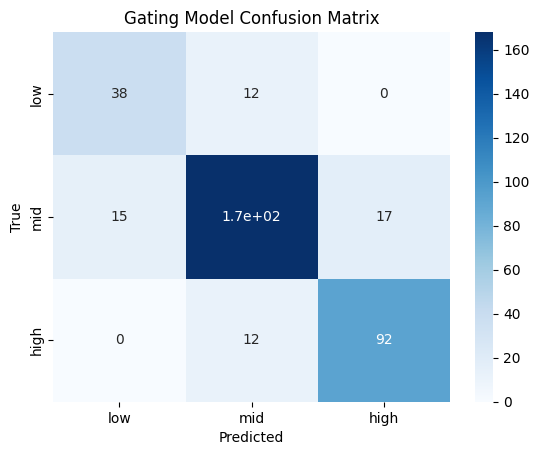

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

gate_preds = gating_model.predict(X_test.cpu()) 

#print(len(gate_preds))

print(classification_report(range_ids_test,gate_preds))

# Confusion matrix
cm = confusion_matrix(range_ids_test, gate_preds)
desired_order_x = [1, 2, 0]  # Modify based on your class arrangement
desired_order_y =  [1, 2, 0]

# Reorder columns and x-tick labels
cm_reordered = cm[:, :]#[:, desired_order_x]
#cm_reordered = cm_reordered[desired_order_y, :]
xticklabels_reordered = desired_order_x[:]# [le.classes_[i] for i in desired_order_x]
yticklabels_reordered =  desired_order_y[:]#[le.classes_[i] for i in desired_order_y]

# le = LabelEncoder()
# le.fit(range_ids) 
sns.heatmap(cm, annot=True, xticklabels=["low", "mid", "high"], yticklabels=["low", "mid", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

In [52]:
# --- 3. Get expert predictions for all samples
pred_low  = model_low.predict(X_test)
pred_mid  = model_mid.predict(X_test)
pred_high = model_high.predict(X_test)

# --- 5. Weighted combination of expert outputs
# gate_probs columns are ordered by le.classes_ => ['high', 'low', 'mid']
# Ensure correct mapping
id_low = 0#= np.where(le.classes_ == 'low')[0][0]
id_mid  =1#= np.where(le.classes_ == 'mid')[0][0]
id_high =2#= np.where(le.classes_ == 'high')[0][0]

final_pred = (
    gate_probs[:, id_low]  * pred_low +
    gate_probs[:, id_mid]  * pred_mid +
    gate_probs[:, id_high] * pred_high
)
# final_pred = []
# for i in range(len(gate_probs)):
#     max_prob = max(gate_probs[i])
#     ind = np.argmax(gate_probs[i])
#     if ind == 0:
#         final_pred.append(pred_low[i])
#     elif ind == 1:
#         final_pred.append(pred_mid[i])     
#     else:
#         final_pred.append(pred_high[i])     
    

# --- 6. Evaluate
rmse = mean_squared_error(y_test.cpu(), final_pred, squared=False)
print(f"Final Mixture-of-Experts RMSE: {rmse:.2f}")



Final Mixture-of-Experts RMSE: 7.03


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


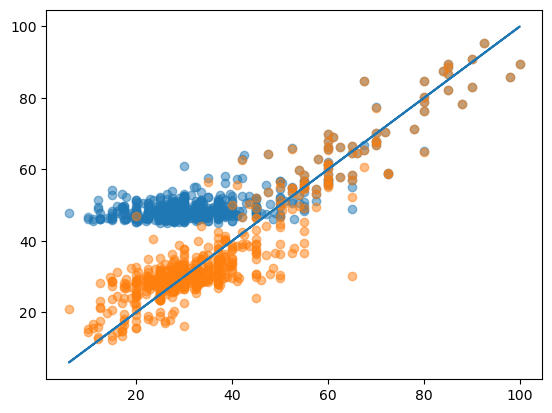

In [39]:
plt.scatter(y_test,pred_high,alpha=0.5)
plt.scatter(y_test,final_pred,alpha=0.5)
plt.plot(y_test,y_test)

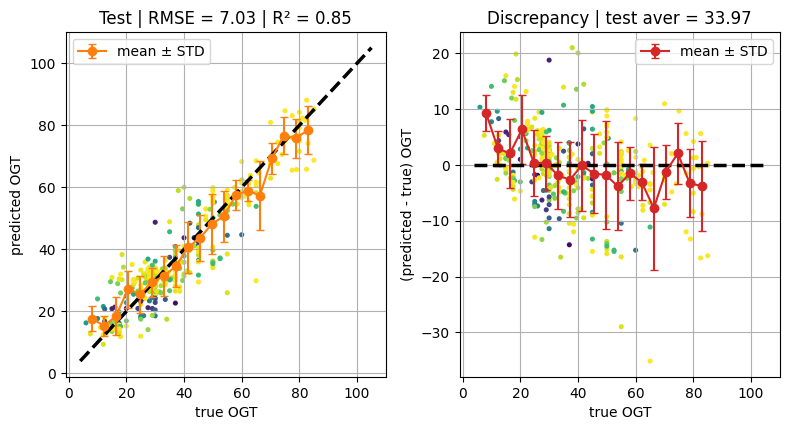

In [55]:
plt.figure(figsize=(8, 8))

y_test = y_test.cpu()

# num_bins = 20
# min_temp = min(y_true_cv.squeeze())
# max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_test.cpu(), final_pred, marker='o', alpha = 1, c = mx_prob, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), final_pred, num_bins)
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze(), final_pred))
r2_test = r2_score(y_test.squeeze(), final_pred)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.legend()
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 2) 
y_test = y_test.cpu()
diff = [final_pred[i] - y_test[i] for i in range(len(final_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 1, c = mx_prob, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
#plt.colorbar()



# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

In [54]:
range_labels_test

label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
encoded_labels = np.vectorize(label_to_int.get)(range_labels_test)
gate_probs


mx_prob = [max(g) for g in gate_probs]
min(mx_prob)

0.49048564

Top 20 important features:
T: 0.2130
E: 0.0956
D: 0.0872
S: 0.0829
R: 0.0480
I: 0.0401
V: 0.0391
N: 0.0376
H: 0.0371
Y: 0.0361
L: 0.0356
M: 0.0322
W: 0.0319
Q: 0.0306
F: 0.0301
C: 0.0286
P: 0.0259
A: 0.0241
G: 0.0225
K: 0.0218


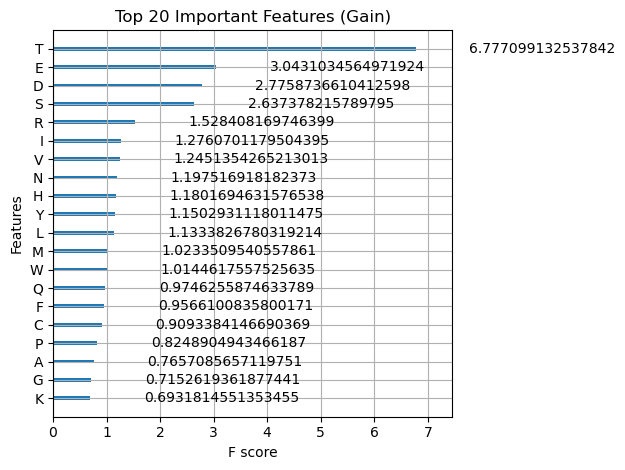

In [44]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances from trained model
importances = gating_model.feature_importances_

# Use your actual column names
feature_names = X_column_names  # Make sure it's a list of strings

# Pair and sort
feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: -x[1])

# Print top features
print("Top 20 important features:")
for feature, score in feature_importance_list[:20]:
    print(f"{feature}: {score:.4f}")

booster = gating_model.get_booster()

# Assign actual feature names
booster.feature_names = list(X_column_names)

# Plot
xgb.plot_importance(gating_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use held-out validation data if possible
y_val_labels = label_ogt_range(y_val)  # true labels
y_val_ids = le.transform(y_val_labels)

# Predict gating model outputs
gate_preds = gating_model.predict(X_val)

# Evaluate classification accuracy
print(classification_report(y_val_ids, gate_preds, target_names=le.classes_))



import pandas as pd

# Visualize softmax output for a few samples
gate_df = pd.DataFrame(gate_probs, columns=le.classes_)
print(gate_df.head())

# Optional: plot histogram of max probabilities (confidence)
import numpy as np
import matplotlib.pyplot as plt

confidences = gate_probs.max(axis=1)
plt.hist(confidences, bins=30)
plt.title("Gating Model Confidence")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Num Samples")
plt.show()

# Compare where gate_preds match the true OGT label
correct_mask = (gate_preds == y_val_ids)

# Final prediction from mixture
final_pred_val = (
    gate_probs[:, id_low]  * model_low.predict(X_val) +
    gate_probs[:, id_mid]  * model_mid.predict(X_val) +
    gate_probs[:, id_high] * model_high.predict(X_val)
)

# RMSE split by gating correctness
from sklearn.metrics import mean_squared_error

rmse_correct = mean_squared_error(y_val[correct_mask], final_pred_val[correct_mask], squared=False)
rmse_wrong   = mean_squared_error(y_val[~correct_mask], final_pred_val[~correct_mask], squared=False)

print(f"RMSE (correctly gated): {rmse_correct:.2f}")
print(f"RMSE (wrongly gated):   {rmse_wrong:.2f}")

NameError: name 'y_val' is not defined

### Two class modelling

In [56]:
# import numpy as np

# # Exclude samples in the range 45 to 50 inclusive
# y_train = y_train.squeeze() 
# mask_train = (y_train < 45) | (y_train > 50)
# X_train = X_train[mask_train]
# y_train = y_train[mask_train]

# y_test = y_test.squeeze() 
# # Same for test set
# mask_test = (y_test < 45) | (y_test > 50)
# #X_test = X_test[mask_test]
# #y_test = y_test[mask_test]


In [57]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error



# --- 1. Label each sample as low, mid, or high OGT group
def label_ogt_range(y,high_thresh=45):
    labels = []
    for val in y:
        if val < high_thresh:
            labels.append('low')
        else:
            labels.append('high')
    return np.array(labels)

# Assign labels
range_labels = label_ogt_range(y_train)

le = LabelEncoder()
range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2

label_to_int = {'low': 0, 'high': 1}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)

range_labels_test = label_ogt_range(y_test)
range_ids_test = np.vectorize(label_to_int.get)(range_labels_test)

(array([232., 122.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

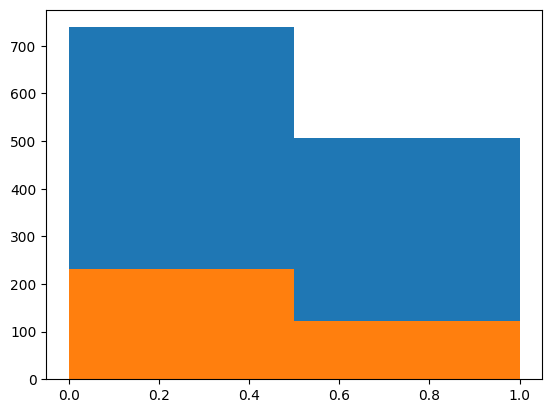

In [58]:
plt.hist(range_ids, bins=2)
plt.hist(range_ids_test, bins=2)

In [62]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Encode classes (0 = low, 1 = mid, 2 = high)
#range_ids = le.transform(label_ogt_range(y_train))

# Compute class weights
classes = np.unique(range_ids)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)
#weights = [4.720125786163522, 0.4315078338364237, 2.1245576786978]

# Convert to dictionary format for xgboost
class_weights = dict(zip(classes, weights))

#class_weights[0]=0.1

# Pass weights to each sample
sample_weights = np.array([class_weights[c] for c in range_ids])

class_weights

{0: 0.8423545331529093, 1: 1.2302371541501975}

In [63]:
num_classes = 2

gating_model = XGBClassifier(
    n_jobs=-1,
    tree_method="hist",
    objective="binary:logistic",   # Binary classification objective
    eval_metric="logloss",         # Suitable for binary classification
)

# gating_model = XGBClassifier(
#     objective="multi:softprob", 
#     num_class=3,
#     eval_metric="mlogloss",
# )

#gating_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')


gating_model.fit(X_train.cpu(), range_ids,sample_weight=sample_weights )  # Predicts soft assignments to experts



# --- 4. Get gating probabilities (soft weights for each expert)
gate_probs = gating_model.predict_proba(X_test.cpu())  # Shape: (n_samples, 3)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       232
           1       0.89      0.86      0.88       122

    accuracy                           0.92       354
   macro avg       0.91      0.90      0.91       354
weighted avg       0.91      0.92      0.91       354



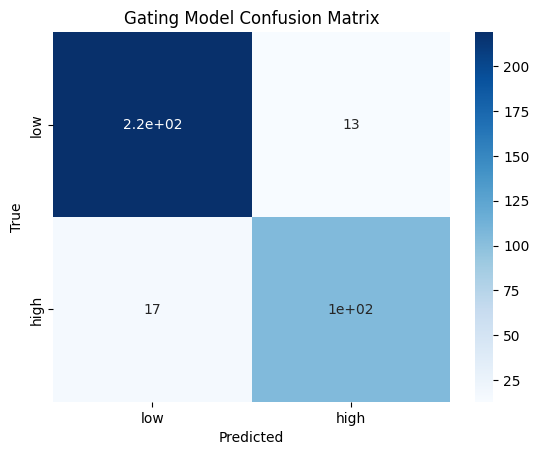

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

gate_preds = gating_model.predict(X_test.cpu()) 

print(classification_report(range_ids_test,gate_preds))

# Confusion matrix
cm = confusion_matrix(range_ids_test, gate_preds)

sns.heatmap(cm, annot=True, xticklabels=["low", "high"], yticklabels=["low", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

In [65]:
from xgboost import XGBRegressor

y_train = y_train.squeeze()

# Define masks (all 1D)
low_mask  = y_train < 45
high_mask = y_train >= 45

# Apply masks correctly
X_low, y_low   = X_train[low_mask].cpu(), y_train[low_mask].cpu()
X_high, y_high = X_train[high_mask].cpu(), y_train[high_mask].cpu()

model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)

In [66]:
y_train

tensor([ 33.5000,  34.5000,  30.0000,  ..., 100.0000, 105.0000, 105.0000])

In [67]:
# --- 3. Get expert predictions for all samples
pred_low  = model_low.predict(X_test)
#pred_mid  = model_mid.predict(X_test)
pred_high = model_high.predict(X_test)

# --- 5. Weighted combination of expert outputs
# gate_probs columns are ordered by le.classes_ => ['high', 'low', 'mid']
# Ensure correct mapping
id_low = 0#= np.where(le.classes_ == 'low')[0][0]
#id_mid  =1#= np.where(le.classes_ == 'mid')[0][0]
id_high =1#= np.where(le.classes_ == 'high')[0][0]

final_pred = (
    gate_probs[:, id_low]  * pred_low +
    #gate_probs[:, id_mid]  * pred_mid +
    gate_probs[:, id_high] * pred_high
)
# final_pred = []
# for i in range(len(gate_probs)):
#     max_prob = max(gate_probs[i])
#     ind = np.argmax(gate_probs[i])
#     if ind == 0:
#         final_pred.append(pred_low[i])
#     elif ind == 1:
#         final_pred.append(pred_mid[i])     
#     else:
#         final_pred.append(pred_high[i])     
    

# --- 6. Evaluate
rmse = mean_squared_error(y_test.cpu(), final_pred, squared=False)
print(f"Final Mixture-of-Experts RMSE: {rmse:.2f}")

gate_probs

Final Mixture-of-Experts RMSE: 6.84


C:\Users\kolda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


array([[9.99123096e-01, 8.76902370e-04],
       [9.99924541e-01, 7.54362336e-05],
       [9.98198748e-01, 1.80126377e-03],
       [9.98611391e-01, 1.38860987e-03],
       [9.96824026e-01, 3.17596435e-03],
       [9.99387860e-01, 6.12162112e-04],
       [9.77743149e-01, 2.22568568e-02],
       [9.98018742e-01, 1.98124466e-03],
       [9.75371182e-01, 2.46287938e-02],
       [9.99456823e-01, 5.43188187e-04],
       [9.94083464e-01, 5.91655495e-03],
       [9.99688625e-01, 3.11391486e-04],
       [9.97162044e-01, 2.83795572e-03],
       [9.99311686e-01, 6.88285916e-04],
       [9.76068497e-01, 2.39314865e-02],
       [9.88608778e-01, 1.13912318e-02],
       [9.99090731e-01, 9.09257389e-04],
       [9.95688498e-01, 4.31152806e-03],
       [9.99259531e-01, 7.40475254e-04],
       [9.99401510e-01, 5.98514162e-04],
       [9.98586237e-01, 1.41375256e-03],
       [9.98751998e-01, 1.24800310e-03],
       [9.53547478e-01, 4.64525148e-02],
       [9.99848425e-01, 1.51601489e-04],
       [9.995158

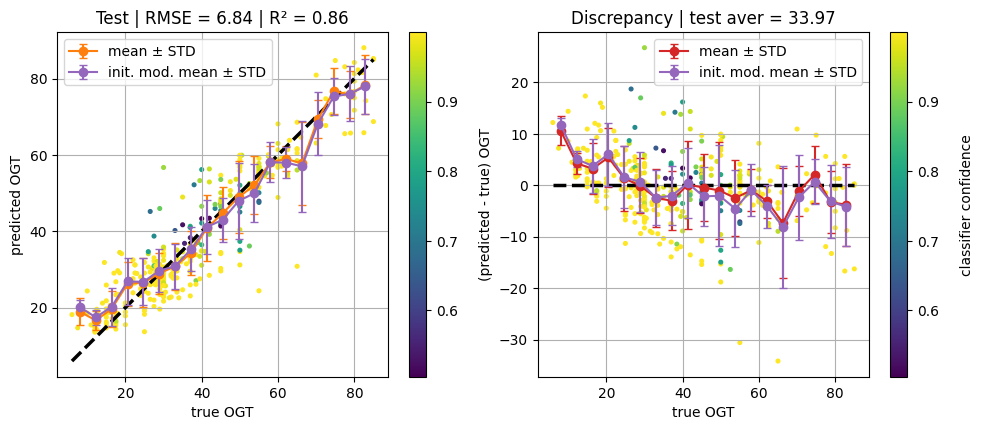

In [68]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


plt.figure(figsize=(10, 8))

y_test = y_test.cpu()
mx_prob = [max(g) for g in gate_probs]

num_bins = 20
min_temp = min(y_test.squeeze())
max_temp = max(y_test.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_test.cpu(), final_pred, marker='o', alpha = 1, c = mx_prob, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), final_pred, num_bins)
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze(), final_pred))
r2_test = r2_score(y_test.squeeze(), final_pred)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")

#plt.errorbar(bin_centers_l, mean_diff_l, yerr=std_diff_l, fmt='o-', color='tab:green', capsize=3, label='test mean ± STD')
#plt.errorbar(bin_centers_ll, mean_diff_ll, yerr=std_diff_ll, fmt='o-', color='tab:purple', capsize=3, label='test mean ± STD')
plt.errorbar(bin_centers_cv_old, mean_diff_cv_old, yerr=std_diff_cv_old, fmt='o-', color='tab:purple', capsize=3, label='init. mod. mean ± STD')
plt.legend()
plt.grid(True)
cbar = plt.colorbar()
#cbar.set_label("classifier confidence", rotation=90, labelpad=15)

# Diff for full signal  
plt.subplot(2, 2, 2) 
y_test = y_test.cpu()
diff = [final_pred[i] - y_test[i] for i in range(len(final_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 1, c = mx_prob, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 

plt.errorbar(bin_centers_test_old, mean_diff_test_old, yerr=std_diff_test_old, fmt='o-', color='tab:purple', capsize=3, label='init. mod. mean ± STD')

plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
cbar = plt.colorbar()
cbar.set_label("classifier confidence", rotation=90, labelpad=15)  # vertical title




# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

Top 20 important features:
T: 0.2079
E: 0.1346
D: 0.1044
V: 0.0862
Y: 0.0614
S: 0.0546
G: 0.0380
R: 0.0368
Q: 0.0360
K: 0.0356
I: 0.0307
H: 0.0298
P: 0.0274
M: 0.0246
W: 0.0236
A: 0.0170
C: 0.0156
L: 0.0141
N: 0.0131
F: 0.0087


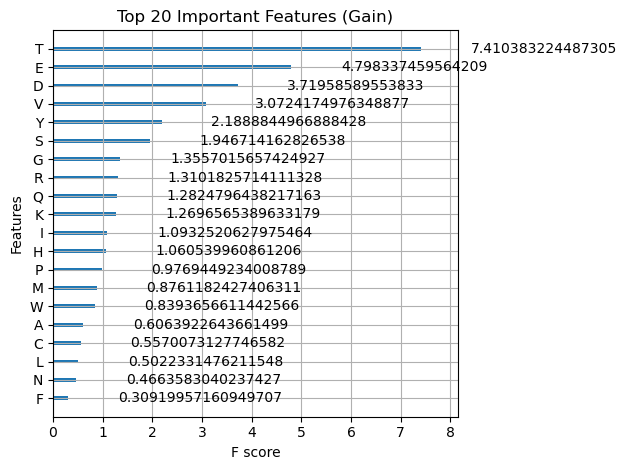

In [55]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances from trained model
importances = gating_model.feature_importances_

# Use your actual column names
feature_names = X_column_names  # Make sure it's a list of strings

# Pair and sort
feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: -x[1])

# Print top features
print("Top 20 important features:")
for feature, score in feature_importance_list[:20]:
    print(f"{feature}: {score:.4f}")

booster = gating_model.get_booster()

# Assign actual feature names
booster.feature_names = list(X_column_names)

# Plot
xgb.plot_importance(gating_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()



Average counts for top 20 features by class:
              T         E         D         V         Y         S         G  \
label                                                                         
0      0.055855  0.061240  0.057238  0.072499  0.029076  0.059058  0.077733   
1      0.049251  0.073411  0.051831  0.076796  0.033689  0.053608  0.075503   

              R         Q         K         I         H         P         M  \
label                                                                         
0      0.057504  0.035825  0.045733  0.058485  0.020512  0.045824  0.023545   
1      0.059942  0.028947  0.056741  0.066984  0.018584  0.045546  0.022815   

              W         A         C         L         N         F  
label                                                              
0      0.012757  0.101465  0.008465  0.100625  0.037001  0.039550  
1      0.011764  0.087067  0.008701  0.103324  0.034865  0.040626  


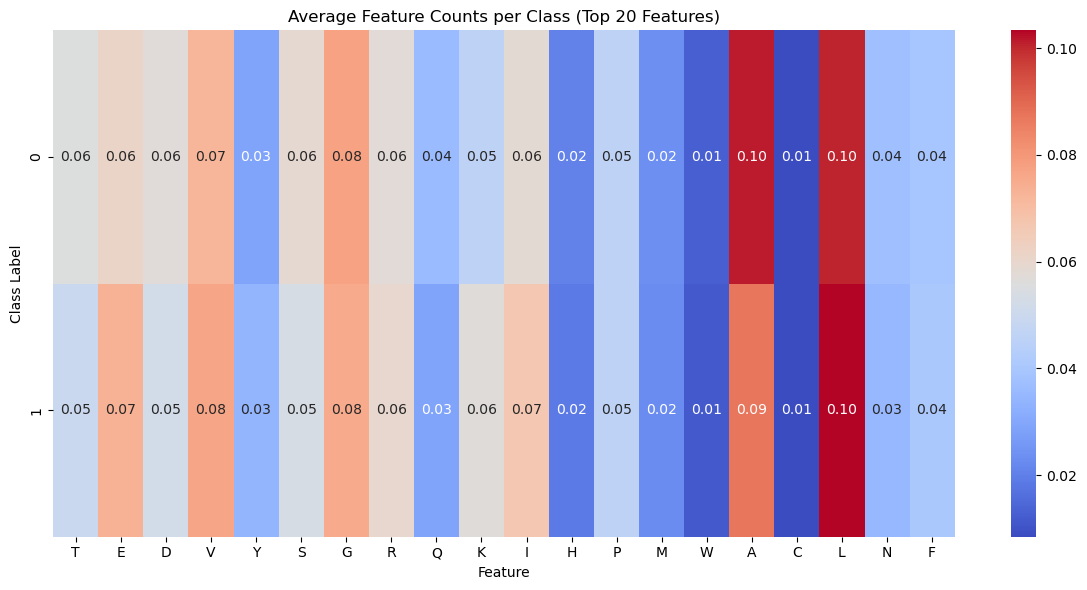

In [56]:
import numpy as np
import pandas as pd

# Convert to DataFrame for easier handling
df = pd.DataFrame(X_train.cpu(), columns=X_column_names)
df['label'] = range_ids

# Top 20 important features
top_features = [f for f, _ in feature_importance_list[:20]]

# Compute average counts for each class
grouped_means = df.groupby('label')[top_features].mean()

# Print results
print("\nAverage counts for top 20 features by class:")
print(grouped_means)

# Optional: visualize as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_means, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Feature Counts per Class (Top 20 Features)")
plt.xlabel("Feature")
plt.ylabel("Class Label")
plt.tight_layout()
plt.show()


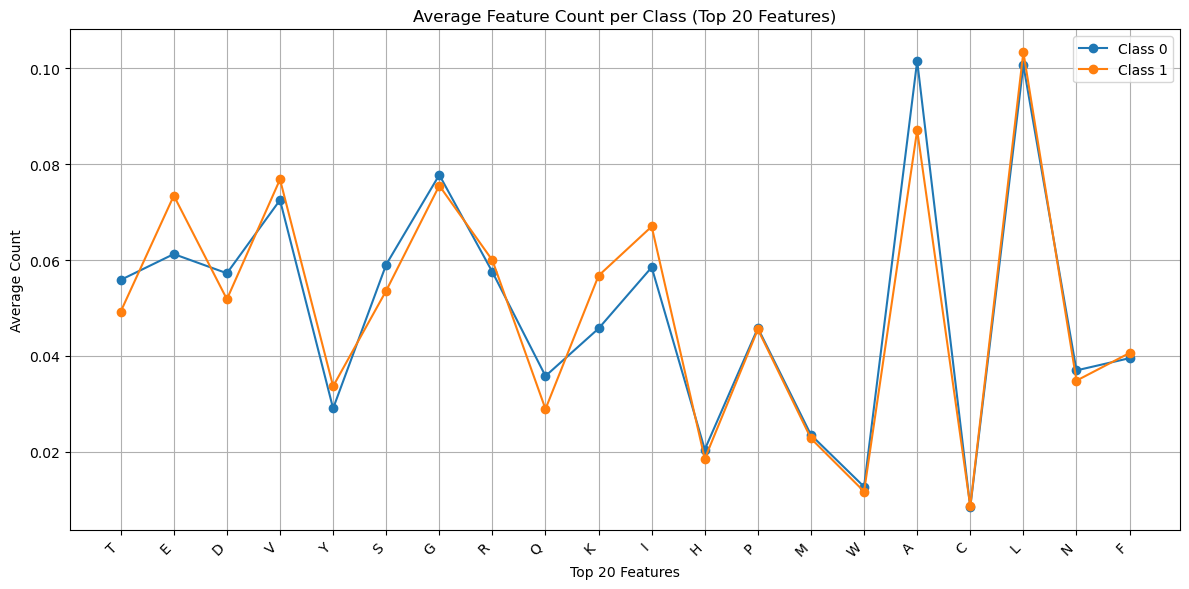

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame if not already
df = pd.DataFrame(X_train.cpu(), columns=X_column_names)
df['label'] = range_ids

# Get top 20 important features
top_features = [f for f, _ in feature_importance_list[:20]]

# Compute mean feature values per class
grouped_means = df.groupby('label')[top_features].mean()

# Plot lines for each class
plt.figure(figsize=(12, 6))

for class_label in grouped_means.index:
    plt.plot(top_features, grouped_means.loc[class_label], marker='o', label=f'Class {class_label}')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Top 20 Features")
plt.ylabel("Average Count")
plt.title("Average Feature Count per Class (Top 20 Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


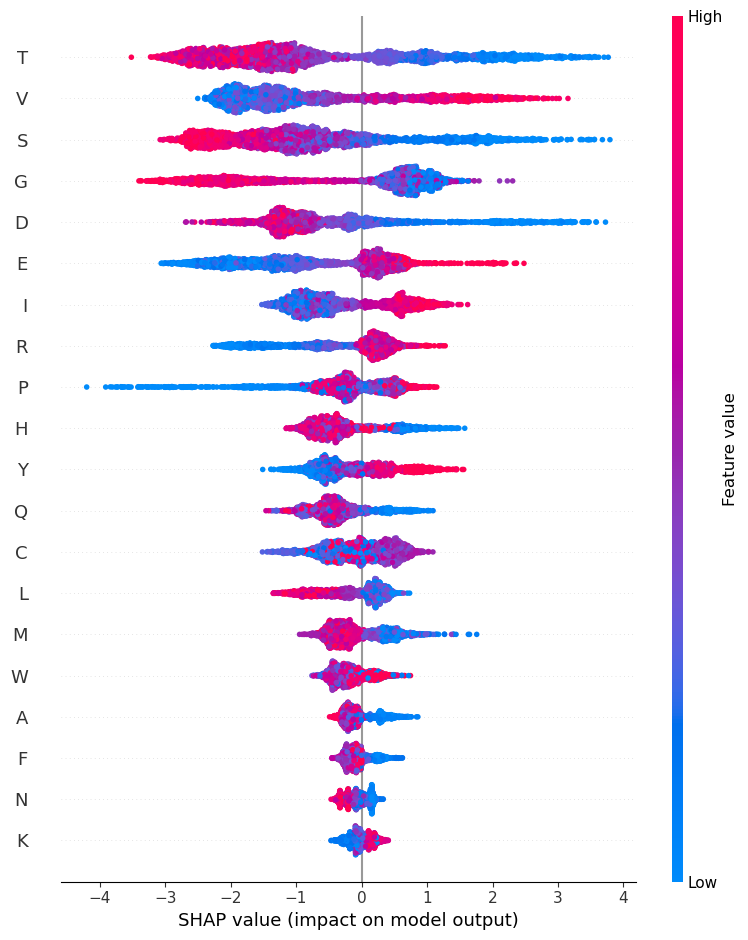

In [58]:
import pandas as pd
import shap

X_train = X_train.cpu()

# If X_train is a NumPy array, convert it:
X_train_df = pd.DataFrame(X_train, columns=X_column_names)

# Recompute SHAP values if needed
explainer = shap.TreeExplainer(gating_model)
shap_values = explainer.shap_values(X_train_df)

# If it's a binary classifier:
shap.summary_plot(shap_values, X_train_df)


In [59]:
from utils.utils import train_xgboost_classification
import torch

y_true_cv, y_pred_cv, y_pred_test = train_xgboost_classification(X_train.cpu(), torch.from_numpy(range_ids), X_test.cpu(), torch.from_numpy(range_ids_test), num_classes=2)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2373
           1       0.91      0.82      0.86       515

    accuracy                           0.95      2888
   macro avg       0.94      0.90      0.92      2888
weighted avg       0.95      0.95      0.95      2888



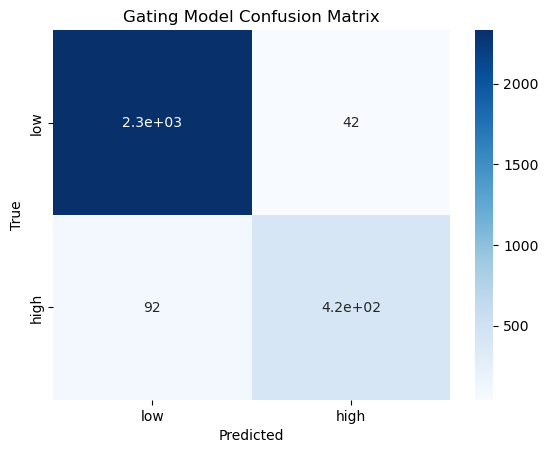

In [60]:
print(classification_report(y_true_cv,y_pred_cv))

# Confusion matrix
cm = confusion_matrix(y_true_cv, y_pred_cv)

sns.heatmap(cm, annot=True, xticklabels=["low", "high"], yticklabels=["low", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

In [135]:
import umap

supervised_umap = umap.UMAP(n_neighbors=50, min_dist=0.1, metric='euclidean')
X_umap = supervised_umap.fit_transform(X_train.cpu(), range_ids)  # supervised mode

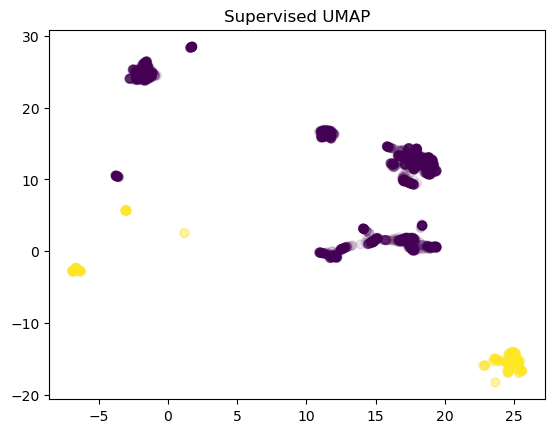

In [136]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=range_ids, cmap='viridis', s=40, alpha=0.1)
plt.title("Supervised UMAP")
plt.show()